AI Training Software  
Copyright (C) 2024 AI Institute, University of South Carolina

Authors:    Homayoun Valafar,
            Andrew Smith,
            Christopher Lee,
            Alireza Bagheri,
            Musa Azim,
            Kuba Jerzmanowski
         

This program is free software: you can redistribute it and/or modify  
it under the terms of the GNU General Public License as published by  
the Free Software Foundation, either version 3 of the License, or  
(at your option) any later version.  

This program is distributed in the hope that it will be useful,  
but WITHOUT ANY WARRANTY; without even the implied warranty of  
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the  
GNU General Public License for more details.  

You should have received a copy of the GNU General Public License  
along with this program. If not, see <https://www.gnu.org/licenses/>.  

For inquiries or permissions, contact: Dr. Valafar (homayoun@cse.sc.edu)


# Machine Learning in Python -  Clustering and Regression Workshop
<a href="https://www.scinbre.org/learning/bids-tutorials-and-workshops/2025-summer-workshops"> SC-INBRE SUMMER '25 Workshop  </a>
### May 28th, 2025

In [1]:
# Import all the libraries we'll need for our workshop
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split


# First hour -  Understanding and Applying Clustering

## What is Clustering and Why Should You Care?

Imagine you're a researcher with a dataset containing information about hundreds of students, including their study habits, test scores, participation levels, and demographic information. You suspect there might be distinct "types" of students in your data, but you don't know what those types are or how many exist.

This is where **clustering** becomes invaluable. Clustering is an unsupervised learning technique that automatically groups similar data points together without requiring you to specify what those groups should be ahead of time.

### Clustering vs. Classification

Before we dive deeper, let's clarify a fundamental concept that often confuses newcomers to machine learning.

**Classification (Supervised Learning):**
- You know the categories ahead of time (e.g., "high performer," "average performer," "struggling student")
- You have examples of data points already labeled with these categories
- Goal: Train a model to predict the category for new, unlabeled data
- Example: Given student data with known performance levels, predict the performance level of a new student

**Clustering (Unsupervised Learning):**
- You don't know what the categories are or should be
- You have no pre-labeled examples
- Goal: Discover natural groupings or patterns in the data
- Example: Analyze student data to discover what types of learners exist in your population

Think of classification as having a set of labeled boxes and learning to sort new items into the correct boxes. Clustering is more like having a pile of items and discovering what natural groups they form when you arrange them by similarity.

## A Simple Example: Understanding Student Study Patterns

Let's start with a concrete example that demonstrates the power of clustering. Imagine we collected data on students' weekly study hours and their preferred study time (measured as hours after noon). We want to see if there are natural groupings of students based on these behaviors.

In [ ]:
# Create synthetic student data that represents different study patterns

# Group 1: "Morning Studiers" - Study early, moderate hours
group1_hours = np.random.normal(loc=15, scale=2, size=50)  # loc = mean, scale = std, size = output shape
group1_time = np.random.normal(2, 1, 50)

# Group 2: "Evening Studiers" - Study late, high hours
group2_hours = np.random.normal(25, 2.5, 50) 
group2_time = np.random.normal(8, 1.5, 50)

# Group 3: "Light Studiers" - Study afternoon, low hours
group3_hours = np.random.normal(8, 1.5, 50)  
group3_time = np.random.normal(5, 1.2, 50)

# Combine
study_hours = np.concatenate([group1_hours, group2_hours, group3_hours])
preferred_time = np.concatenate([group1_time, group2_time, group3_time])

student_data = pd.DataFrame({
    'weekly_study_hours': study_hours,
    'preferred_study_time': preferred_time
})


print(f"We have data on {len(student_data)} students")
print("\nFirst few rows of our data:")
print(student_data.head(10))

In [ ]:
# Let's visualize this data to see what patterns might exist
plt.figure(figsize=(10, 6))
plt.scatter(student_data['weekly_study_hours'], student_data['preferred_study_time'], s=50, c='gray')
plt.xlabel('Weekly Study Hours')
plt.ylabel('Preferred Study Time (hours after noon)')
plt.title('Student Study Patterns')
plt.grid(True, alpha=0.3)

# Hortizontal lines for context
plt.axhline(y=0, color='blue', linestyle='--', alpha=0.5, label='Noon')
plt.axhline(y=6, color='orange', linestyle='--', alpha=0.5, label='6 PM')
plt.legend()

plt.tight_layout()
plt.show()

print("Looking at this plot, can you identify distinct groups of students?")

## The K-Means Algorithm: Step by Step

Now that we can visually see there might be groups in our data, let's learn how a computer can discover these groups automatically using the K-means algorithm. K-means is one of the most popular and intuitive clustering algorithms.

### How K-Means Works: The Intuition

Imagine you're organizing a potluck dinner and you want to arrange people into conversation groups. You might:

1. **Choose the number of groups** you want (this is the "K" in K-means)
2. **Place group leaders** randomly around the room
3. **Assign each person** to the closest group leader
4. **Move each group leader** to the center of their group
5. **Repeat steps 3-4** until the groups stabilize

K-means follows exactly this process, but with data points instead of people!

### The K-Means Algorithm in Detail

Let's implement K-means step by step to understand exactly how it works:

In [ ]:
def demonstrate_kmeans_steps_fixed(data, k=3, max_iterations=10):
    """
    Demonstrate K-means clustering step by step with visualizations.
    Fixed version that properly assigns points to closest centroids.
    """
    # Step 1: Initialize centroids randomly
    np.random.seed(69)
    centroids = np.random.rand(k, 2)
    centroids[:, 0] = centroids[:, 0] * (data[:, 0].max() - data[:, 0].min()) + data[:, 0].min()
    centroids[:, 1] = centroids[:, 1] * (data[:, 1].max() - data[:, 1].min()) + data[:, 1].min()
    
    colors = ['red', 'blue', 'green', 'purple', 'orange']
    
    # Visualize initial setup
    plt.figure(figsize=(12, 8))
    plt.scatter(data[:, 0], data[:, 1], c='gray', alpha=0.6, s=50, label='Data Points')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='o', 
               s=300, linewidths=3, facecolors='white', edgecolors='black', 
               label='Initial Centroids')
    plt.xlabel('Weekly Study Hours')
    plt.ylabel('Preferred Study Time (hours after noon)')
    plt.title('Initial Setup - Before K-Means')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    for iteration in range(max_iterations):
        # Step 2: Assign each point to the closest centroid
        distances = np.zeros((len(data), k))
        for i, centroid in enumerate(centroids):
            distances[:, i] = np.sqrt(np.sum((data - centroid)**2, axis=1))
        
        # Find the closest centroid for each point
        closest_centroid = np.argmin(distances, axis=1)
        
        # Step 3: Update centroids to the mean of assigned points
        new_centroids = np.zeros_like(centroids)
        for i in range(k):
            cluster_points = data[closest_centroid == i]
            if len(cluster_points) > 0:
                new_centroids[i] = cluster_points.mean(axis=0)
            else:
                new_centroids[i] = centroids[i]
        
        # Visualize this iteration
        plt.figure(figsize=(12, 8))
        
        # Plot points colored by their cluster assignment
        for i in range(k):
            cluster_points = data[closest_centroid == i]
            if len(cluster_points) > 0:
                plt.scatter(cluster_points[:, 0], cluster_points[:, 1], c=colors[i], alpha=0.7, s=50, label=f'Cluster {i+1}')
        
        # Plot old centroids (smaller, with X)
        plt.scatter(centroids[:, 0], centroids[:, 1], c='black', marker='x', s=250, linewidths=4, label='Old Centroids')
        
        # Plot new centroids (larger, filled circles)
        plt.scatter(new_centroids[:, 0], new_centroids[:, 1], c='black', marker='o', s=250, linewidths=3, facecolors='white', edgecolors='black', label='New Centroids')
        
        plt.xlabel('Weekly Study Hours')
        plt.ylabel('Preferred Study Time (hours after noon)')
        plt.title(f'K-Means Iteration {iteration + 1}')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()
        
        # Check for convergence
        if np.allclose(centroids, new_centroids, rtol=1e-4):
            print(f"Converged after {iteration + 1} iterations!")
            break
        
        centroids = new_centroids.copy()
    
    return new_centroids, closest_centroid

    
final_centroids, final_assignments = demonstrate_kmeans_steps_fixed(np.vstack([study_hours, preferred_time]).T, k=3)

## Using Scikit-Learn for K-Means Clustering

While it's valuable to understand how K-means works internally, in practice we typically use well-tested implementations like those in scikit-learn. Let's see how to apply K-means to our student data using the professional tools:

In [6]:
# Apply K-means clustering using scikit-learn
from sklearn.cluster import KMeans 


# We'll start by assuming we want 3 clusters (we'll learn how to choose this number later)
kmeans = KMeans(n_clusters=3, random_state=42)

In [ ]:
print(np.vstack([study_hours, preferred_time]).T.shape)
data = np.vstack([study_hours, preferred_time]).T
cluster_labels = kmeans.fit_predict(data)
cluster_labels

In [ ]:
# Add cluster labels to our DataFrame
student_data['cluster'] = cluster_labels
student_data

In [ ]:
# Visualize the results
plt.figure(figsize=(12, 6))

# Plot 1: Original data without clustering
plt.scatter(student_data['weekly_study_hours'], student_data['preferred_study_time'], s=50, c='gray')
plt.xlabel('Weekly Study Hours')
plt.ylabel('Preferred Study Time (hours after noon)')
plt.title('Original Data (No Clustering)')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
# Plot 2: Data with K-means clustering
plt.figure(figsize=(12, 6))

# Create the scatter plot
scatter = plt.scatter(student_data['weekly_study_hours'], student_data['preferred_study_time'], s=50, c=student_data['cluster'], cmap='plasma')
# Create a colorbar legend for clusters
cbar = plt.colorbar(scatter)
cbar.set_label('Cluster Number')


# Plot the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='x', s=200, linewidths=3, label='Centroids')

plt.xlabel('Weekly Study Hours')
plt.ylabel('Preferred Study Time (hours after noon)')
plt.title('K-Means Clustering Results')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

If you prefer discrete legend entries for each cluster

In [ ]:
# Plot 2: Data with K-means clustering
plt.figure(figsize=(12, 6))

# Get unique clusters and colors
unique_clusters = np.unique(student_data['cluster'])
colors = ['red', 'green', 'blue']

# Plot each cluster with its own legend entry
for i, cluster_id in enumerate(unique_clusters):
    mask = student_data['cluster'] == cluster_id
    plt.scatter(student_data.loc[mask, 'weekly_study_hours'], student_data.loc[mask, 'preferred_study_time'], 
               s=50, c=[colors[i]], label=f'Cluster {cluster_id}')

# Plot the centroids
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black', marker='x', s=200, linewidths=3, label='Centroids')

plt.xlabel('Weekly Study Hours')
plt.ylabel('Preferred Study Time (hours after noon)')
plt.title('K-Means Clustering Results')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Cluster Analysis:

In [ ]:

for i in range(3): # We have three clusters 0,1,2
    cluster_data = student_data[student_data['cluster'] == i]
    avg_hours = cluster_data['weekly_study_hours'].mean()
    avg_time = cluster_data['preferred_study_time'].mean()
    count = len(cluster_data)
    
    print(f"\nCluster {i+1} ({count} students):")
    print(f"  Average study hours per week: {avg_hours:.1f}")

    # Interpret the time
    if avg_time < 3:
        time_description = "Early Afternoon"
    elif avg_time < 6:
        time_description = "Late Afternoon"
    else:
        time_description = "Evening"
    

    print(f"  Preferred study time: {time_description} ({avg_time:.1f} hours after noon)")
    
    # Give each cluster a descriptive name
    if avg_hours > 20:
        intensity = "High-Intensity"
    elif avg_hours > 12:
        intensity = "Moderate"
    else:
        intensity = "Light"
    

    print(f"  Profile: {intensity} {time_description} Studiers")

## Choosing the Right Number of Clusters: The Elbow Method

One of the biggest challenges in clustering is determining how many clusters your data naturally contains. We chose 3 clusters above, but how do we know that's the right number? 

The **Elbow Method** is a popular technique for finding the optimal number of clusters. It works by measuring how "tight" the clusters are for different values of k and looking for the point where adding more clusters doesn't significantly improve the clustering quality.


<br><br>
We will use `itertia` a measure of how well a dataset has been grouped by the algorithm.

It represents the sum of the squared distances between each data point and the centroid of its assigned cluster

In [ ]:
inertias = []

for k in range(1, 11): # 1-10
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data)
    inertias.append(kmeans.inertia_) 

In [ ]:
# Plot the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertias, 'bo-', markersize=8, linewidth=2)
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('The Elbow Method: Finding Optimal Number of Clusters')
plt.grid(True, alpha=0.3)

# Highlight the "elbow" point
plt.axvline(x=3, color='red', linestyle='--', alpha=0.7, label='Potential Elbow at k=3')
plt.legend()

plt.tight_layout()
plt.show()

Interpretation:
- As k increases, inertia always decreases (clusters get tighter)
- The 'elbow' represents the best trade-off between cluster tightness and simplicity
- Beyond the elbow, adding more clusters doesn't provide much benefit

## Hour 1 Exercise: 

For this exercise, you will be working with an artificial dataset given by us.



In [ ]:
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

centers = [[1, 1], [-1, -1], [1, -1]]
X, labels_true = make_blobs(n_samples=750, centers=centers, cluster_std=0.4, random_state=0)

X = StandardScaler().fit_transform(X)

1. Vizualize the data. 

In [ ]:
plt.figure(figsize=(10, 6))
plt.scatter(X[:, 0], X[:, 1], s=50, c=labels_true)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


2. Use the elbow method to find the optimal number of clusters

In [ ]:
inertias = []

for k in range(1,11): # Try k's ranging from 1-10.
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_) 

inertias

In [ ]:
plt.plot(range(1,11), inertias)
plt.grid(alpha=0.8)
plt.show()

3. Apply K-means clustering with the optimal k

In [ ]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=5)
res  = kmeans.fit(X)

4. Visualize and interpret the results. (Note: the result of the `.fit()` operation will have attributes like `.labels_` and `.cluster_centers_` that might be useful for this task.)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], s=50, c=res.labels_, cmap='plasma')
plt.scatter(res.cluster_centers_[:,0], res.cluster_centers_[:,1], c='black', s=150, label='Centroid')
plt.legend()
plt.show()

---

# Hour 2: Understanding and Applying Regression

## What is Regression and Why Does It Matter?

If clustering helps us discover hidden patterns in data, regression helps us understand and predict relationships between variables. While clustering asks "What groups exist in my data?", regression asks "How does changing X affect Y?"

### Real-World Regression Examples Across Disciplines

**Education:**
- How do study hours relate to exam scores?
- Can we predict student retention based on first-semester performance?
- How does class size affect learning outcomes?

**Chemistry:**
- How does temperature affect chemical reaction rates?

**Biology:**
- Can we predict population growth from environmental factors?

**Social Sciences:**
- How does income relate to educational attainment?
- Can we predict voting behavior from demographic data?

### The Core Idea of Regression

Regression finds the best mathematical relationship between an **input variable** (called the independent variable, predictor, or feature) and an **output variable** (called the dependent variable, target, or response). The simplest form is linear regression, which finds the best straight line through your data points.

## Linear Regression: Finding the Best Line

Let's start with a concrete example that many educators will find familiar: the relationship between study time and exam performance.

In [ ]:
# Create a realistic dataset showing the relationship between study hours and exam scores
np.random.seed(42)

# Generate study hours (independent variable)
study_hours = np.random.uniform(0, 20, 100)  # 0 to 20 hours of study

# Create exam scores with a realistic relationship to study hours
# Base score + (study effect * hours) + some randomness
exam_scores = 50 + 2.5 * study_hours + np.random.normal(0, 8, 100)
exam_scores

In [ ]:
# Ensure scores stay within realistic bounds (0-100)
exam_scores = np.clip(exam_scores, 0, 100)
exam_scores

In [ ]:
# Create DataFrame
study_data = pd.DataFrame({
    'study_hours': study_hours,
    'exam_score': exam_scores
})

# Visualize the relationship
plt.figure(figsize=(10, 6))
plt.scatter(study_hours, exam_scores, s=50)
plt.xlabel('Study Hours per Week')
plt.ylabel('Exam Score')
plt.title('Relationship Between Study Time and Exam Performance')
plt.grid(True, alpha=0.3)

In [ ]:
# Calculate and display correlation
correlation = np.corrcoef(study_hours, exam_scores)[0, 1]
correlation

## Implementing Linear Regression Step by Step

Linear regression finds the line that best fits through the data points. This line is described by the equation:

**y = mx + b**

Where:
- **y** is the predicted exam score
- **x** is the study hours
- **m** is the slope (how much the score increases per hour of study)
- **b** is the y-intercept (the predicted score with zero study hours)

The algorithm finds the values of m and b that minimize the distance between the actual data points and the predicted line.

In [ ]:
# Implement linear regression using scikit-learn
# First, we need to reshape our data for scikit-learn
X = study_hours.reshape(-1, 1)  # Features must be 2D array
y = exam_scores  # Target can be 1D array
X.shape, y.shape

In [ ]:
# Create and fit the linear regression model
linear_model = LinearRegression()
linear_model.fit(X, y)

In [ ]:
# Make predictions
y_pred = linear_model.predict(X)
y_pred

In [ ]:
# Extract the slope and intercept
slope = linear_model.coef_[0]
intercept = linear_model.intercept_
slope, intercept

In [ ]:
print(f"Equation: exam_score = {slope:.2f} * study_hours + {intercept:.2f}")
print(f"\nInterpretation:")
print(f"• Each additional hour of study increases exam score by {slope:.2f} points")
print(f"• A student who doesn't study is predicted to score {intercept:.1f} points")

In [ ]:
# Visualize the regression line
plt.figure(figsize=(10, 6))
plt.scatter(study_hours, exam_scores, alpha=0.6, s=50, label='Actual Data')
plt.plot(study_hours, y_pred, color='red', linewidth=2, label=f'Regression Line: y = {slope:.2f}x + {intercept:.2f}')
plt.xlabel('Study Hours per Week')
plt.ylabel('Exam Score')
plt.title('Linear Regression: Study Hours vs Exam Scores')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Evaluating Regression Performance

How do we know if our regression model is good? We use several metrics to evaluate performance:

1. **R² Score (Coefficient of Determination)**: Measures how much of the variation in exam scores is explained by study hours. Ranges from 0 to 1, where 1 means perfect prediction.

2. **Mean Squared Error (MSE)**: Average of squared differences between actual and predicted values. Lower is better.

3. **Root Mean Squared Error (RMSE)**: Square root of MSE, in the same units as our target variable.

In [ ]:
# Calculate evaluation metrics
r2 = r2_score(y, y_pred)
mse = mean_squared_error(y, y_pred)
rmse = np.sqrt(mse)

In [ ]:

print("Model Performance Evaluation:")
print("="*40)
print(f"R² Score: {r2:.3f}")
print(f"  → {r2*100:.1f}% of exam score variation is explained by study hours")
print(f"\nMean Squared Error: {mse:.2f}")
print(f"Root Mean Squared Error: {rmse:.2f} points")
print(f"  → On average, predictions are off by ±{rmse:.1f} points")

## When Linear Regression Fails: Non-Linear Relationships

Linear regression assumes a straight-line relationship between variables. But what happens when the real relationship is curved? Let's explore this with a common scenario: the relationship between practice time and skill improvement.

In many learning scenarios, initial practice has a big impact, but additional practice yields diminishing returns (a curved relationship).

In [ ]:
# Create data with a non-linear relationship
np.random.seed(42)

# Practice hours
practice_hours = np.linspace(0, 20, 100)

# Skill improvement follows a logarithmic curve (diminishing returns)
# High initial gains, but improvements slow down with more practice
true_skill = 15 * np.log(practice_hours + 1) + np.random.normal(0, 3, 100)
true_skill = np.maximum(true_skill, 0)  # Skill can't be negative
plt.scatter(practice_hours, true_skill)

In [ ]:

# Try linear regression on this non-linear data
X_practice = practice_hours.reshape(-1, 1)
y_skill = true_skill

# Fit linear model
linear_model_nonlinear = LinearRegression()
linear_model_nonlinear.fit(X_practice, y_skill)
y_pred_linear = linear_model_nonlinear.predict(X_practice)

In [ ]:
# Calculate performance metrics
r2_linear = r2_score(y_skill, y_pred_linear)
rmse_linear = np.sqrt(mean_squared_error(y_skill, y_pred_linear))


In [ ]:
# Plot 1: Linear regression
plt.scatter(practice_hours, true_skill, alpha=0.6, s=50, label='Actual Data')
plt.plot(practice_hours, y_pred_linear, color='red', linewidth=2, label='Linear Fit')
plt.xlabel('Practice Hours')
plt.ylabel('Skill Improvement')
plt.title(f'Linear Regression\nR² = {r2_linear:.3f}, RMSE = {rmse_linear:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

In [ ]:
# Fit polynomial model (degree 2)
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X_practice)
poly_model = LinearRegression()
poly_model.fit(X_poly, y_skill)
y_pred_poly = poly_model.predict(X_poly)

In [ ]:
# Calculate performance metrics
r2_poly = r2_score(y_skill, y_pred_poly)
rmse_poly = np.sqrt(mean_squared_error(y_skill, y_pred_poly))

In [ ]:
# Plot 2: Polynomial regression
plt.scatter(practice_hours, true_skill, alpha=0.6, s=50, label='Actual Data')
plt.plot(practice_hours, y_pred_poly, color='green', linewidth=2, label='Polynomial Fit')
plt.xlabel('Practice Hours')
plt.ylabel('Skill Improvement')
plt.title(f'Polynomial Regression\nR² = {r2_poly:.3f}, RMSE = {rmse_poly:.2f}')
plt.legend()
plt.grid(True, alpha=0.3)

Performance Comparison:

In [ ]:
print(f"Linear Regression:     R² = {r2_linear:.3f}, RMSE = {rmse_linear:.2f}")
print(f"Polynomial Regression: R² = {r2_poly:.3f}, RMSE = {rmse_poly:.2f}")
print(f"\nImprovement: {((r2_poly - r2_linear) / r2_linear * 100):.1f}% better R²")

Key Insights:
- Linear regression fails when the relationship is curved
- Polynomial regression can capture non-linear patterns
- Look at residual plots to detect non-linear relationships
- The residuals should show no clear pattern if the model fits well

## Understanding When Linear Regression Works and When It Doesn't

Linear regression makes several important assumptions. When these assumptions are violated, the model may perform poorly or give misleading results. Let's explore the key assumptions with visual examples:

In [ ]:
# Create different scenarios to illustrate when linear regression works and fails
np.random.seed(42)
x = np.linspace(0, 10, 100)

# Scenario 1: Perfect for linear regression
y1 = 2 * x + 3 + np.random.normal(0, 1, 100)

# Scenario 2: Non-linear relationship
y2 = x**2.5 + np.random.normal(0, 3, 100)

# Scenario 3: Heteroscedasticity (changing variance)
y3 = 2 * x + np.random.normal(0, x * 0.5, 100)

# Scenario 4: Outliers present
y4 = 2 * x + 3 + np.random.normal(0, 1, 100)
y4[10] += 15  # Add an outlier
y4[13] += 13  # Add another outlier
y4[15] += 11.3  # Add another outlier
y4[18] += 13  # Add another outlier

y4[8] += 9  # Add another outlier
y4[45] += 10  # Add another outlier
y4[50] += 12  # Add another outlier

scenarios = [
    (y1, "Good: Linear Relationship", "Linear regression works well"),
    (y2, "Poor: Non-linear Relationship", "Consider polynomial regression"),
    (y3, "Poor: Changing Variance", "Violates equal variance assumption"),
    (y4, "Caution: Outliers Present", "Outliers can skew the line")
]

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for i, (y, title, explanation) in enumerate(scenarios):
    # Fit linear regression
    model = LinearRegression()
    X_reshaped = x.reshape(-1, 1)
    model.fit(X_reshaped, y)
    y_pred = model.predict(X_reshaped)
    
    # Calculate R²
    r2 = r2_score(y, y_pred)
    
    # Plot
    axes[i].scatter(x, y, alpha=0.6, s=30)
    axes[i].plot(x, y_pred, color='red', linewidth=2)
    axes[i].set_xlabel('X Variable')
    axes[i].set_ylabel('Y Variable')
    axes[i].set_title(f'{title}\nR² = {r2:.3f}')
    axes[i].grid(True, alpha=0.3)
    
    # Add explanation
    axes[i].text(0.02, 0.98, explanation, transform=axes[i].transAxes,
                verticalalignment='top', 
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.show()

When to Use Linear Regression:

✅ GOOD cases:
   - Relationship appears linear in scatter plots
   - Residuals are randomly scattered around zero
   - Variance is consistent across the range of X
   - Few or no extreme outliers

❌ PROBLEMATIC cases:
   - Clear curved patterns in the data
   - Residuals show systematic patterns
   - Variance increases/decreases with X
   - Extreme outliers pull the line away from the main pattern

🔧 SOLUTIONS when linear regression fails:
   - Polynomial regression for curved relationships
   - Transform variables (log, square root, etc.)
   - Robust regression methods for outliers
   - Consider other algorithms (decision trees, neural networks)

## Hour 2 Exercise:

For this exercise, you will work with synthetic data representing the relationship between advertising spending and sales revenue.


In [ ]:

# Generate synthetic advertising vs sales data
np.random.seed(123)

# Create advertising spending data (in thousands of dollars)
advertising_spend = np.random.uniform(10, 100, 150)

# Create sales revenue with a realistic relationship to advertising
# Base sales + advertising effect + some randomness + diminishing returns
sales_revenue = 50 + 2.5 * advertising_spend - 0.01 * advertising_spend**2 + np.random.normal(0, 8, 150)

# Ensure no negative sales
sales_revenue = np.maximum(sales_revenue, 0)

print(f"Generated {len(advertising_spend)} data points")
print(f"Advertising range: ${advertising_spend.min():.1f}k to ${advertising_spend.max():.1f}k")
print(f"Sales range: ${sales_revenue.min():.1f}k to ${sales_revenue.max():.1f}k")


Generated 150 data points
Advertising range: $10.2k to $99.6k
Sales range: $78.5k to $211.1k


1. **Visualize the relationship** between advertising spend and sales revenue

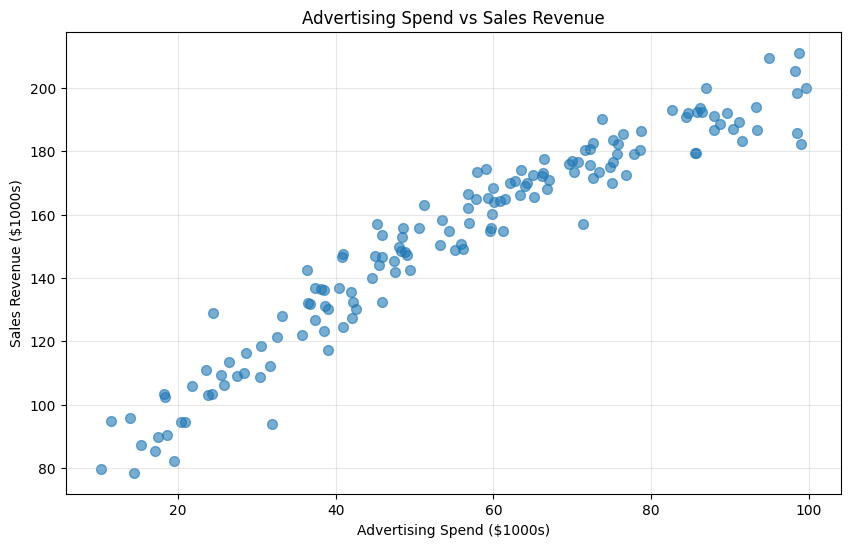

In [184]:
plt.figure(figsize=(10, 6))
plt.scatter(advertising_spend, sales_revenue, alpha=0.6, s=50)
plt.xlabel('Advertising Spend ($1000s)')
plt.ylabel('Sales Revenue ($1000s)')
plt.title('Advertising Spend vs Sales Revenue')
plt.grid(True, alpha=0.3)
plt.show()


2. **Fit a linear regression model** (Name the model: `linear_model`)

In [187]:
X_ad = advertising_spend.reshape(-1, 1)
y_sales = sales_revenue

linear_model = LinearRegression()
linear_model.fit(X_ad, y_sales)
y_pred_linear = linear_model.predict(X_ad)

In [188]:

# Extract coefficients
slope = linear_model.coef_[0]
intercept = linear_model.intercept_
print(f"Linear model: sales = {slope:.2f} * advertising + {intercept:.2f}")

Linear model: sales = 1.32 * advertising + 78.83


3. **Fit a polynomial regression model (degree 2)**

In [189]:
poly_features = PolynomialFeatures(degree=2)
X_poly = poly_features.fit_transform(X_ad)

poly_model = LinearRegression()
poly_model.fit(X_poly, y_sales)
y_pred_poly = poly_model.predict(X_poly)

4. **Compare model performance** (Calculate R² and RMSE for both models)

In [190]:
r2_linear = r2_score(y_sales, y_pred_linear)
r2_poly = r2_score(y_sales, y_pred_poly)

rmse_linear = np.sqrt(mean_squared_error(y_sales, y_pred_linear))
rmse_poly = np.sqrt(mean_squared_error(y_sales, y_pred_poly))

In [191]:
print("Model Performance Comparison:")
print(f"Linear:     R² = {r2_linear:.3f}, RMSE = {rmse_linear:.2f}")
print(f"Polynomial: R² = {r2_poly:.3f}, RMSE = {rmse_poly:.2f}")

Model Performance Comparison:
Linear:     R² = 0.920, RMSE = 9.04
Polynomial: R² = 0.949, RMSE = 7.24


5. **Visualize both models** (Plot data points and both regression lines)

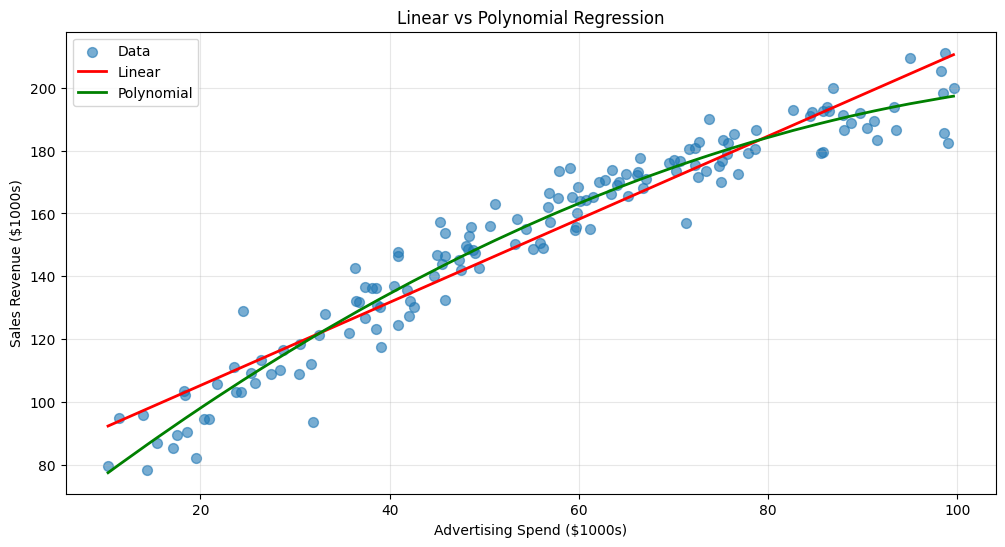

In [192]:
plt.figure(figsize=(12, 6))

# Sort data for smooth polynomial line
sort_idx = np.argsort(advertising_spend)
x_sorted = advertising_spend[sort_idx]
y_linear_sorted = y_pred_linear[sort_idx]
y_poly_sorted = y_pred_poly[sort_idx]

plt.scatter(advertising_spend, sales_revenue, alpha=0.6, s=50, label='Data')
plt.plot(x_sorted, y_linear_sorted, color='red', linewidth=2, label='Linear')
plt.plot(x_sorted, y_poly_sorted, color='green', linewidth=2, label='Polynomial')

plt.xlabel('Advertising Spend ($1000s)')
plt.ylabel('Sales Revenue ($1000s)')
plt.title('Linear vs Polynomial Regression')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Homework

## Exercise 1: Student Performance Clustering

In [14]:
# Generate student performance data
np.random.seed(456)

# Profile 1: High achievers
high_achievers = np.random.multivariate_normal([85, 90, 88], [[25, 10, 15], [10, 20, 12], [15, 12, 30]], 40)

# Profile 2: Steady performers  
steady_performers = np.random.multivariate_normal([70, 75, 72], [[20, 5, 8], [5, 25, 10], [8, 10, 20]], 35)

# Profile 3: Test anxious (good homework, poor exams)
test_anxious = np.random.multivariate_normal([80, 60, 70], [[15, -5, 5], [-5, 30, 0], [5, 0, 25]], 30)

You are analyzing student performance data to identify different learning profiles.

1. Combine all profiles into a dataframe (Note: Keep scores in 0-100 range, using `np.vstack` might help)

In [15]:
all_students = np.vstack([high_achievers, steady_performers, test_anxious]) #, inconsistent])
np.clip(all_students, 0, 100, out=all_students)  # Keep scores in 0-100 range
student_df = pd.DataFrame(all_students, columns=['homework_avg', 'exam_avg', 'participation'])

2. Standardize the data

In [16]:
standard_student_df = student_df.copy()
print(f"Pre Normalization:\n{student_df.head()}")

standard_student_df['homework_avg'] = (student_df['homework_avg'] - student_df['homework_avg'].mean()) / student_df['homework_avg'].std()
standard_student_df['exam_avg'] = (student_df['exam_avg'] - student_df['exam_avg'].mean()) / student_df['exam_avg'].std()
standard_student_df['participation'] = (student_df['participation'] - student_df['participation'].mean()) / student_df['participation'].std()


print(f"Post Normalization:\n{standard_student_df.head()}")

Pre Normalization:
   homework_avg   exam_avg  participation
0     86.301714  90.933613      93.263424
1     86.554684  81.953265      86.106674
2     85.056370  89.517765      85.117058
3     80.495719  96.533792      90.742397
4     90.232635  94.262923      92.363950
Post Normalization:
   homework_avg  exam_avg  participation
0      0.937338  1.128617       1.654438
1      0.970601  0.437954       0.912718
2      0.773589  1.019726       0.810155
3      0.173912  1.559316       1.393161
4      1.454212  1.384668       1.561217


3. Use the elbow method to determine the optimal number of clusters

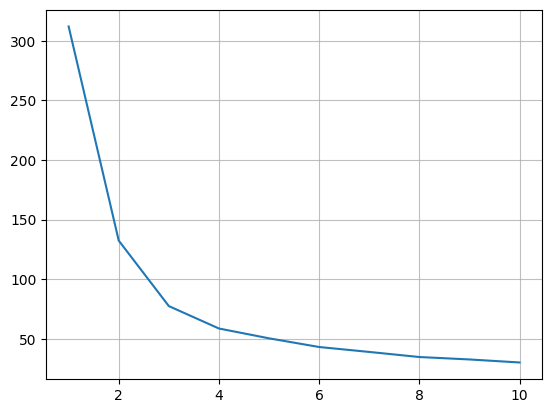

In [17]:
inertias = []

for k in range(1,11): # Try k's ranging from 1-10.
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=5)
    kmeans.fit(standard_student_df)
    inertias.append(kmeans.inertia_) 

inertias
plt.plot(range(1,11), inertias)
plt.grid(alpha=0.8)
plt.show()

3. Apply K-means clustering with the optimal k

In [18]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init=5)
res  = kmeans.fit(standard_student_df)

4. Create visualizations showing the clusters (use pair plots or multiple scatter plots)


Use:
```
import seaborn as sns                           
sns.pairplot(standard_student_df, hue="cluster")
```
Note: To color by cluster you must add cluster value to the DataFrame. Think: `standard_student_df['cluster'] = res.labels_`

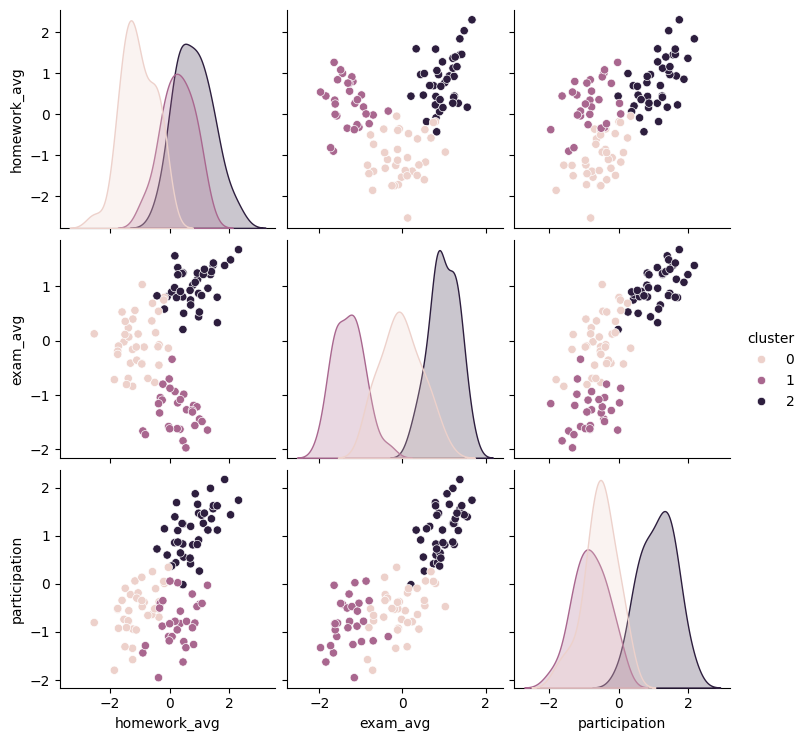

In [22]:
standard_student_df['cluster'] = res.labels_
import seaborn as sns
sns.pairplot(standard_student_df, hue="cluster")

## Exercise 2: Sales Forecasting 

A local ice cream shop wants to understand how daily temperature affects their sales.


In [25]:
# Generate simple temperature vs ice cream sales data
np.random.seed(42)

# Daily temperature (Fahrenheit)
temperature = np.random.uniform(60, 95, 50)  # 50 days of data, 60-95°F

# Ice cream sales (number of scoops sold)
# Relationship: hotter days = more ice cream sales
ice_cream_sales = 20 + 3 * temperature + np.random.normal(0, 15, 50)
ice_cream_sales = np.maximum(ice_cream_sales, 0) # Make sure sales aren't negative

print(f"Temperature range: {temperature.min():.1f}°F to {temperature.max():.1f}°F")
print(f"Sales range: {ice_cream_sales.min():.0f} to {ice_cream_sales.max():.0f} scoops")

Temperature range: 60.7°F to 93.9°F
Sales range: 194 to 323 scoops


1. Visualize the relationship

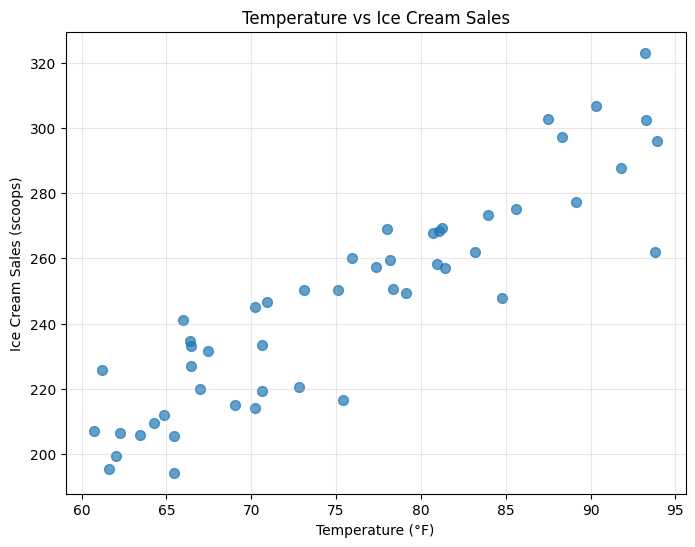

In [26]:
plt.figure(figsize=(8, 6))
plt.scatter(temperature, ice_cream_sales, alpha=0.7, s=50)
plt.xlabel('Temperature (°F)')
plt.ylabel('Ice Cream Sales (scoops)')
plt.title('Temperature vs Ice Cream Sales')
plt.grid(True, alpha=0.3)
plt.show()

2. Build a linear regression model

In [27]:
X = temperature.reshape(-1, 1)  # Reshape for sklearn
y = ice_cream_sales

model = LinearRegression()
model.fit(X, y)

LinearRegression()

3. Make predictions. (Extract the slope `.coef_` and intercept `.intercept_`)

In [28]:
# Get predictions
y_pred = model.predict(X)

# Extract slope and intercept
slope = model.coef_[0]
intercept = model.intercept_

4. Evaluate the model with R^2 and RMSE

In [30]:
r2 = r2_score(y, y_pred)
rmse = np.sqrt(mean_squared_error(y, y_pred))

print(f"R² Score: {r2:.3f}")
print(f"RMSE: {rmse:.1f} scoops")

R² Score: 0.820
RMSE: 13.6 scoops


5. Visualize the regression line

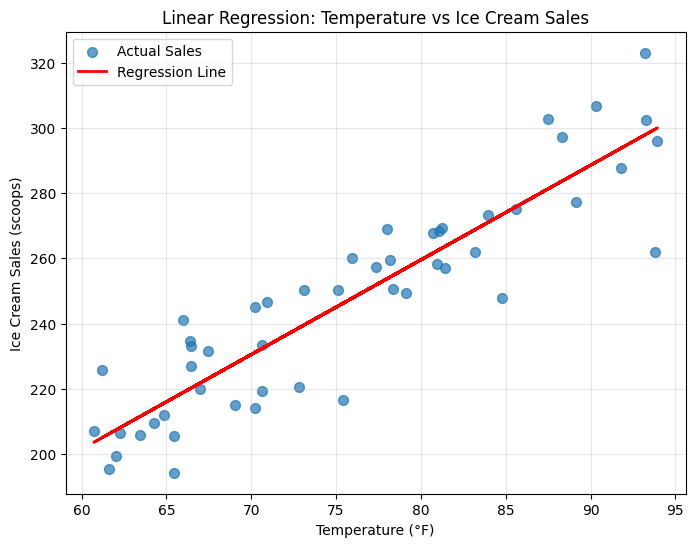

In [31]:
plt.figure(figsize=(8, 6))
plt.scatter(temperature, ice_cream_sales, alpha=0.7, s=50, label='Actual Sales')
plt.plot(temperature, y_pred, color='red', linewidth=2, label='Regression Line')
plt.xlabel('Temperature (°F)')
plt.ylabel('Ice Cream Sales (scoops)')
plt.title('Linear Regression: Temperature vs Ice Cream Sales')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

6. Get predictions the values `[[70], [75], [82]]` (Note: Pass to the `.predict(X)`)

In [43]:
test_temps = [[70], [80], [90]]
preds = model.predict(test_temps)
print(f"At {test_temps[0][0]}°F -> {preds[0]:.1f} scoops |  At {test_temps[1][0]}°F -> {preds[1]:.1f} scoops | At {test_temps[2][0]}°F -> {preds[2]:.1f} scoops ")

At 70°F -> 230.5 scoops |  At 80°F -> 259.5 scoops | At 90°F -> 288.6 scoops 
